In [436]:
import os
import numpy as np
from tensorflow.keras.models import load_model
from GPUtil import getFirstAvailable
from models import MODELS
import nibabel as nib

from matplotlib import pyplot as plt

from scipy.spatial.transform import Rotation

from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.image as mpimg

In [4]:
os.environ["CUDA_VISIBLE_DEVICES"] = str(getFirstAvailable(order="load", maxLoad=0.1, maxMemory=0.1)[0])

In [424]:
#model_path = "../models/Entrack/conditional/2019-11-04-21:55:21/model_T=0.0202.h5"
#model_path = "../models/Entrack/conditional/2019-11-13/22:24:08/model_T=0.0196.h5" # min val-loss
#model_path = "../models/Entrack/conditional/2019-11-24/01:18:33/model_T=0.0020.h5"
model_path = "../models/Entrack/conditional/2019-11-24/01:18:33/model_T=0.0052.h5"
#model_path = "../models/Entrack/conditional/2019-11-24/01:18:33/model_T=0.0199.h5"
#model_path = "../models/Entrack/conditional/2019-11-24/01:18:33/model_T=0.0446.h5"
model_name = model_path.split("/")[2]

In [425]:
model = load_model(model_path,
                   custom_objects=MODELS[model_name].custom_objects,
                   compile=False)

In [7]:
dwi_img = nib.load("../subjects/992774/fod_norm.nii.gz")
dwi = dwi_img.get_data()

In [347]:
peaks_img = nib.load("peaks_992774.nii.gz")
peaks = peaks_img.get_data()

In [365]:
# Strong unidirectional signal (left-right)
vox_lr = dwi[72,89,74,:]

vox_lr_clean = np.array([ 0.31,  0,  0, 0, 0,
        0.44297972,  0, 0, 0 , 0,
        0, 0 , 0,  0,  0.28 ], dtype="float32")
vox_lr_clean /= np.linalg.norm(vox_lr_clean)
vox_lr_clean *= np.linalg.norm(vox_lr)

peak_lr = peaks[72,89,74]

# Strong unidirectional signal (superior-inferior)
vox_si = dwi[87,85,84,:]
vox_si_clean=np.array([ 3e-01, 
        0,  0,  3.5e-01,
0, 0, 0, 0, 0,  0,  0,  0, 0,  0, 0], dtype="float32")
vox_si_clean /= np.linalg.norm(vox_si_clean)
vox_si_clean *= np.linalg.norm(vox_si)

peak_si = peaks[87,85,84]

# Strong unidirectional signal (anterior-posterior)
vox_ap = dwi[77,107,78,:]

# Voxel outside of white matter (but inside of brain) with low signal amplitude, and no clear direction
vox_no_diff1 = dwi[48, 130, 50, :] # small ventricle
vox_no_diff2 = dwi[70, 112, 65, :] # large ventricle
vox_no_diff3 = dwi[18, 91, 39, :] # outside of brain

# Clear 90° crossing of two directions
vox_cross = dwi[90, 99, 81, :]

vox_cross_clean = np.array([
    3e-01,
    1.5e-01, 0,  1.5e-01, 0,  1.5e-01, 
    0, 0, 1.2e-01,  0, -1.2e-01, 0, 1.2e-01,  0,  0], dtype="float32")
vox_cross_clean /= np.linalg.norm(vox_cross_clean)
vox_cross_clean *= np.linalg.norm(vox_cross)


peak_cross = peaks[90, 99, 81]

In [411]:
img = vox_lr.reshape(1,1,1,-1)

img = nib.nifti1.Nifti1Image(img, dwi_img.affine, dwi_img.header)

nib.loadsave.save(img, "vox_lr.nii.gz")

In [115]:
def make_no_diff_block(strength):
    
    vox_no_diff = np.zeros(15)
    vox_no_diff[0] = strength
    
    return make_uniform_block(vox_no_diff)

In [9]:
def make_uniform_block(vox, knockout=None):
    block = vox * np.ones([3,3,3,15])
    
    if knockout is None:
        return block
    else:
        idx = np.unravel_index(knockout, (3,3,3))
        block[idx[0],idx[1],idx[2]] = vox_no_diff3 # instead of 0
        return block

In [10]:
def place_vox(vox, i):
    #block = np.zeros([3,3,3,15])
    block = make_uniform_block(vox_no_diff3)
    idx = np.unravel_index(i, (3,3,3))
    block[idx[0],idx[1],idx[2]] = vox
    return block

In [11]:
def make_input_vec(vin, d):
    dnorm = np.linalg.norm(d) + 10**-2
    du = (d / dnorm).flatten()
    return np.hstack([vin, du, dnorm]).reshape(1,-1)

In [ ]:
def make_input_vecs(vin, d):
    dnorm = np.linalg.norm(d, axis=-1) + 10**-2
    du = d / dnorm
    return np.hstack([vin, du, dnorm])

In [12]:
def predict(model, vin, d, return_fvm=False):
    input_vec = make_input_vec(vin, d)
    fvm, kappa = model(input_vec)
    if return_fvm:
        return fvm.mean_direction.numpy()[0], kappa.numpy()[0], fvm
    else:
        return fvm.mean_direction.numpy()[0], kappa.numpy()[0]

In [ ]:
def predict(model, vin, d, return_fvm=False):
    
    if vin.ndim == 1:
    
        input_vec = make_input_vec(vin, d)
        fvm, kappa = model(input_vec)
        if return_fvm:
            return fvm.mean_direction.numpy()[0], kappa.numpy()[0], fvm
        else:
            return fvm.mean_direction.numpy()[0], kappa.numpy()[0]
        
    else:
        
        d = np.tile(d, [len(vin), 1])
        input_vecs = make_input_vecs(vin, d)
        fvm, kappa = model(input_vecs)
        
        if return_fvm:
            return fvm.mean_direction.numpy()[0], kappa.numpy()[0], fvm
        else:
            return fvm.mean_direction.numpy()[0], kappa.numpy()[0]

In [321]:
def plot_rot(vin, d, rot_dir):
    angles = np.linspace(-np.pi, np.pi, 100)
    k = []
    dev = []
    plt.figure(dpi=100)
    for angle in angles:
        rot = Rotation.from_rotvec(np.array(rot_dir) * angle)
        vrot = rot.apply(vin)
        mu, kappa = predict(model, vrot, d)
        k.append(kappa)
        dev.append(np.arccos(np.sum(mu*vrot)) / np.pi *180)
    fig, ax1 =plt.subplots(dpi=100)
    ax1.plot(angles/np.pi*180, k, "-", color="tab:blue")
    ax1.set_xlabel("angle (°)")
    ax1.set_ylabel(r"$\kappa$", color="tab:blue")
    ax1.tick_params(axis='y', labelcolor="tab:blue")
    #ax1.set_ylim(47.5,51)
    
    ax2 = ax1.twinx()
    ax2.plot(angles/np.pi*180, dev, "-", color="tab:orange")
    ax2.set_ylabel(r"deviation $\mu^Tv_{in}$ (°)", color="tab:orange")
    ax2.tick_params(axis='y', labelcolor="tab:orange")
    #ax2.set_ylim(0,25)
    fig.tight_layout() 

# Zero diffusion data, no incoming direction
This is a bit artifical, because the model is per definition conditional, i.e. it always expects an incoming direction in the input.

In [88]:
vin = [0,0,0]
d = np.zeros([3,3,3,15])
predict(model, vin, d)

(array([-0.34365255,  0.80498666, -0.48363167], dtype=float32), 485.53885)

In [89]:
vin = [0,0,0]
d = make_uniform_block(vox_no_diff)
predict(model, vin, d)

(array([-0.98717165, -0.00964311,  0.1593712 ], dtype=float32), 487.93338)

# Zero diffusion data with incoming direction
We can observe, that in the absence of a diffusion signal, the output direction is strongly influenced by the incoming direction. Moreover, the certainty is considerably higher than without vin.

In [86]:
vin = [1,0,0]
d = np.zeros([3,3,3,15])
predict(model, vin, d)

(array([ 0.9378961 , -0.1842769 , -0.29392666], dtype=float32), 501.1076)

In [116]:
vin = [1,0,0]
d = make_no_diff_block(0.1)
predict(model, vin, d)

(array([0.98165965, 0.11252366, 0.15389185], dtype=float32), 486.91846)

# Rotate vin with zero diffusion data
Here we rotate vin around the z-axis (green) and observe how the ouput direction (red) follows along, and how its uncertainty changes (length).

WEIRD: We would expect a more constant kappa, and also lower.

<Figure size 600x400 with 0 Axes>

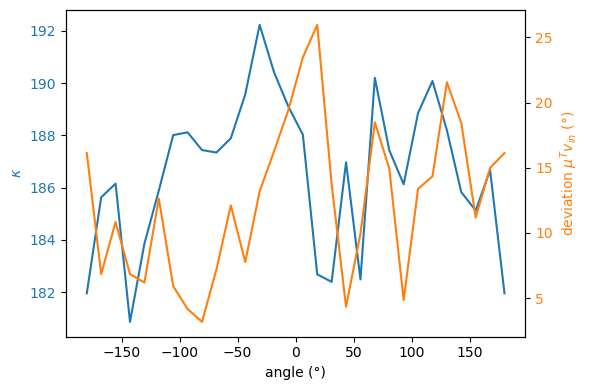

In [229]:
plot_rot(vin=[1,0,0], d=np.zeros([3,3,3,15]), rot_dir=[0,0,1]);

# Rotate vin with single clear direction
The block consists entirely of a single strong direction, and now we rotate vin out-of-plane (at angle=0, vin is perpendicular to the main direction, at angle=90 it points in the same direction)

In [356]:
peak_lr[:3] / np.linalg.norm(peak_lr[:3])

array([-0.9998383 , -0.01585601,  0.00847952], dtype=float32)

In [355]:
peak_lr[3:6] / np.linalg.norm(peak_lr[3:6])

array([ 0.02080958,  0.9870446 , -0.15909165], dtype=float32)

In [437]:
fod_lr = mpimg.imread('vox_lr1.png')

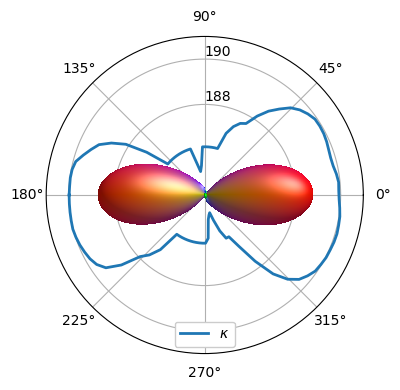

In [452]:
#r2gcolors = cm.get_cmap('brg', 256)(np.linspace(0.5, 1, 256))
#r2gcmp = ListedColormap(r2gcolors)

d=make_uniform_block(vox_lr)
vin = peak_lr[:3] / np.linalg.norm(peak_lr[:3])
rot_dir = peak_lr[3:6] / np.linalg.norm(peak_lr[3:6])

theta = np.linspace(-np.pi, np.pi, 100)
plt.figure(dpi=100)
ax = plt.subplot(111, projection='polar')
k = []
dev = []
sig=[]
for th in theta:
    rot = Rotation.from_rotvec(np.array(rot_dir) * th)
    vrot = rot.apply(vin)
    mu, kappa = predict(model, vrot, d)
    k.append(kappa)
    
    dev.append(np.arccos(np.sum(mu*vrot)) / np.pi *180 )
    sig.append(np.sum(mu*vin) - np.sum(vrot*vin) > 0)


ax.set_ylim(184,191)
#ax.scatter(theta, dev, linewidth=2, c=["r" if s>0 else "b" for s in sig])

imagebox = OffsetImage(fod_lr, zoom=0.11)

ab = AnnotationBbox(imagebox, (184., 184.), bboxprops=dict(facecolor='none', edgecolor='none'))

ax.add_artist(ab)
ax.plot(theta, k, linewidth=2, label=r"$\kappa$")

#ax.set_rmax(3)
ax.set_rticks([188, 190])  # less radial ticks
ax.set_rlabel_position(90)  # get radial labels away from plotted line
ax.grid(True)
plt.legend(loc="lower center", framealpha=1)
plt.tight_layout()
plt.savefig("case_lr_kappa.png", bbox_inches=0)

W1125 21:58:12.414081 140373745993472 legend.py:1282] No handles with labels found to put in legend.


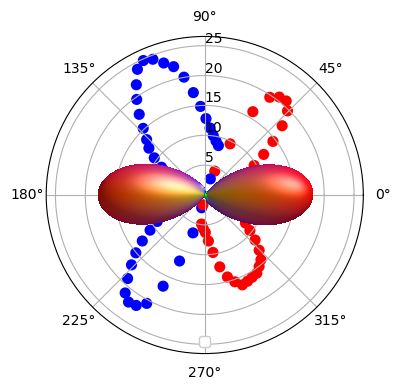

In [455]:
#r2gcolors = cm.get_cmap('brg', 256)(np.linspace(0.5, 1, 256))
#r2gcmp = ListedColormap(r2gcolors)

d=make_uniform_block(vox_lr)
vin = peak_lr[:3] / np.linalg.norm(peak_lr[:3])
rot_dir = peak_lr[3:6] / np.linalg.norm(peak_lr[3:6])

theta = np.linspace(-np.pi, np.pi, 140)
plt.figure(dpi=100)
ax = plt.subplot(111, projection='polar')
k = []
dev = []
sig=[]
for th in theta:
    rot = Rotation.from_rotvec(np.array(rot_dir) * th)
    vrot = rot.apply(vin)
    mu, kappa = predict(model, vrot, d)
    k.append(kappa)
    
    dev.append(np.arccos(np.sum(mu*vrot)) / np.pi *180 )
    sig.append(np.sum(mu*vin) - np.sum(vrot*vin) > 0)

#ax.set_ylim(184,191)
ax.scatter(theta, dev, linewidth=2, marker=".",
           c=["r" if s>0 else "b" for s in sig])

imagebox = OffsetImage(fod_lr, zoom=0.11)

ab = AnnotationBbox(imagebox, (0., 0.), bboxprops=dict(facecolor='none', edgecolor='none'))

ax.add_artist(ab)
#ax.plot(theta, k, linewidth=2, label=r"$\kappa$")

#ax.set_rmax(3)
#ax.set_rticks([188, 190])  # less radial ticks
ax.set_rlabel_position(90)  # get radial labels away from plotted line
ax.grid(True)
plt.legend(loc="lower center", framealpha=1)
plt.tight_layout()
#plt.savefig("case_lr_kappa.png", bbox_inches=0)

<Figure size 600x400 with 0 Axes>

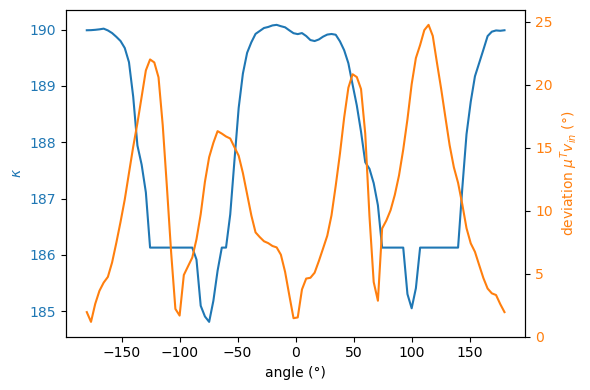

In [426]:
plot_rot(vin=[-0.9998383 , -0.01585601,  0.00847952],
         d=make_uniform_block(vox_lr), rot_dir=[0.02080958,  0.9870446 , -0.15909165])

<Figure size 600x400 with 0 Axes>

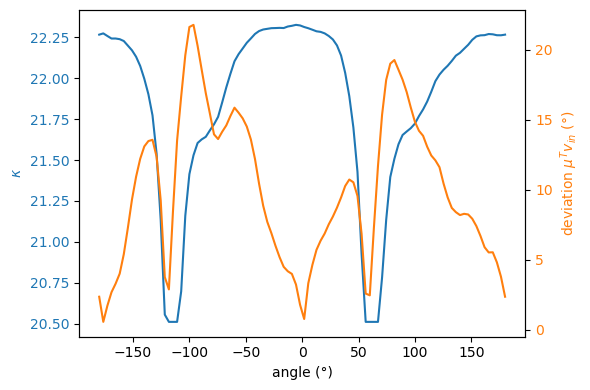

In [407]:
plot_rot(vin=[-0.9998383 , -0.01585601,  0.00847952],
         d=make_uniform_block(vox_lr), rot_dir=[0.02080958,  0.9870446 , -0.15909165])

<Figure size 600x400 with 0 Axes>

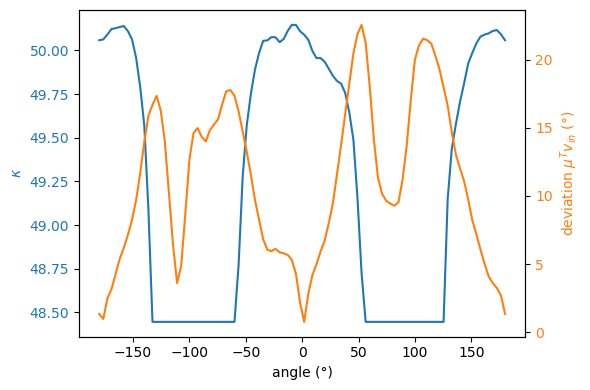

In [404]:
plot_rot(vin=[-0.9998383 , -0.01585601,  0.00847952],
         d=make_uniform_block(vox_lr), rot_dir=[0.02080958,  0.9870446 , -0.15909165])

<Figure size 600x400 with 0 Axes>

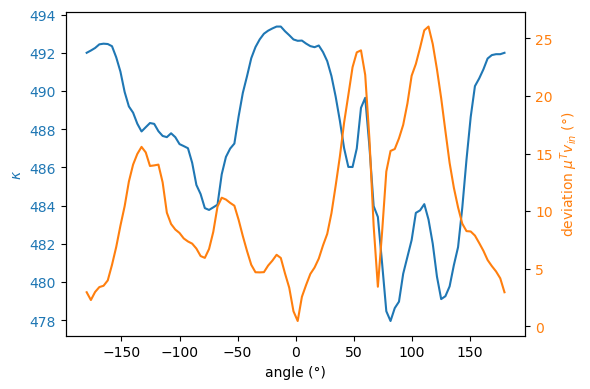

In [410]:
plot_rot(vin=[-0.9998383 , -0.01585601,  0.00847952],
         d=make_uniform_block(vox_lr), rot_dir=[0.02080958,  0.9870446 , -0.15909165])

In [360]:
peak_si[:3] / np.linalg.norm(peak_si[:3])

array([-0.02761405, -0.08757745,  0.995775  ], dtype=float32)

In [361]:
peak_si[3:6] / np.linalg.norm(peak_si[3:6])

array([ 0.48696426, -0.87312037,  0.02294815], dtype=float32)

<Figure size 600x400 with 0 Axes>

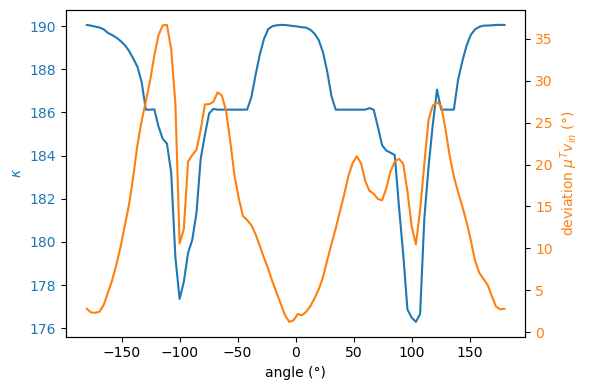

In [363]:
plot_rot(vin=[-0.02761405, -0.08757745,  0.995775  ], 
         d=make_uniform_block(vox_si), rot_dir=[ 0.48696426, -0.87312037,  0.02294815])

# Crossing
We rotate vin, while the diffusion data is a clear 90° crossing. We expect a double-peak behavior of the uncertainty, corresponding to the presence of two main directions

In [366]:
peak_cross[:3] / np.linalg.norm(peak_cross[:3])

array([-0.7071771 , -0.0578335 ,  0.70466715], dtype=float32)

In [367]:
peak_cross[3:6] / np.linalg.norm(peak_cross[3:6])

array([0.6201302 , 0.24183093, 0.74629503], dtype=float32)

In [369]:
np.cross([-0.7071771 , -0.0578335 ,  0.70466715], [0.6201302 , 0.24183093, 0.74629503])

array([-0.21357117,  0.96474814, -0.135153  ])

<Figure size 600x400 with 0 Axes>

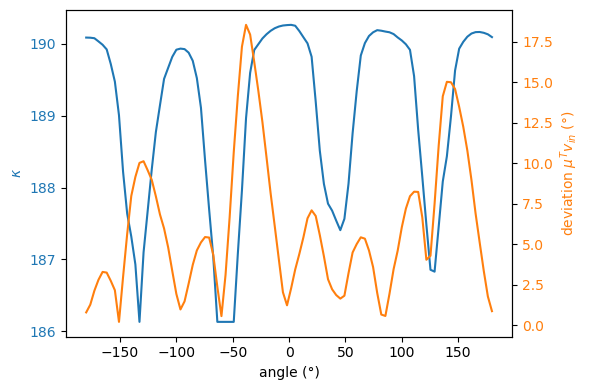

In [370]:
plot_rot(vin=[-0.7071771 , -0.0578335 ,  0.70466715],
         d=make_uniform_block(vox_cross), rot_dir=[-0.21357117,  0.96474814, -0.135153  ])

<Figure size 600x400 with 0 Axes>

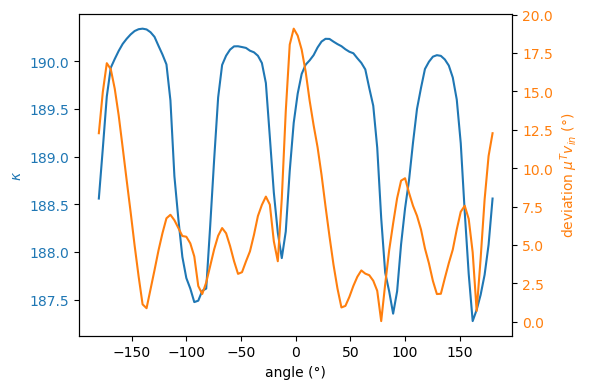

In [371]:
plot_rot(vin=[1,0,0], d=make_uniform_block(vox_cross), rot_dir=[0,1,0])

<Figure size 600x400 with 0 Axes>

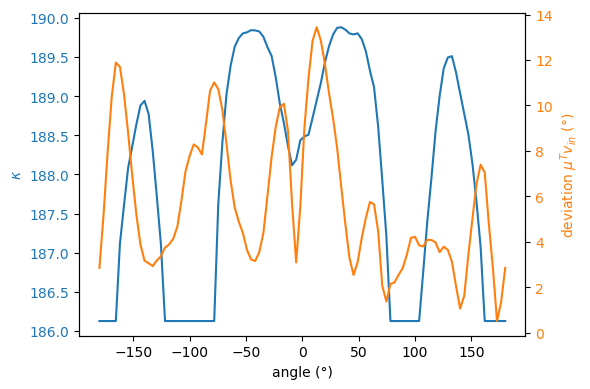

In [322]:
plot_rot(vin=[1,0,0], d=make_uniform_block(vox_cross_clean), rot_dir=[0,1,0])

# Signal Strength
Now we keep vin and the diffusion direction fixed, and vary only the magnitude of the diffusion signal

In [375]:
def from_isotropic_to_si(w):
    
    vox = np.array([0.39252377, 0.        , 0.        , 0.45794436, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ],
      dtype="float32")
    
    
    
    vox_norm = np.linalg.norm(vox)
    vox[3] *= w
    vox /= np.linalg.norm(vox)
    vox *= vox_norm
    
    return vox
    

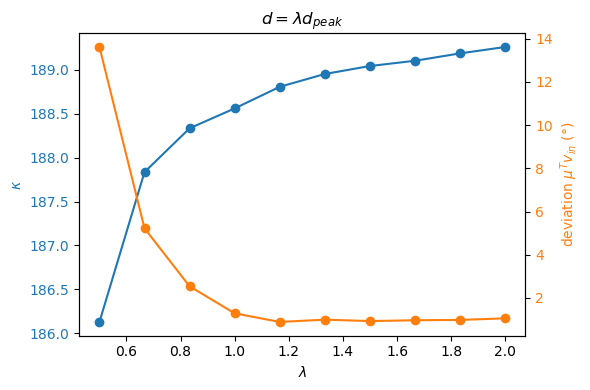

In [381]:
vin = [0,0,1]
d = make_uniform_block(vox_si)

k = []
dev = []
weights = np.linspace(0.5, 2, 10)
for w in weights:
    vox = from_isotropic_to_si(w)
    block = make_uniform_block(vox)
    mu, kappa = predict(model, vin, block)
    k.append(kappa)
    dev.append(np.arccos(np.sum(mu*vin)) / np.pi *180)

fig, ax1 =plt.subplots(dpi=100)
ax1.plot(weights, k, "-o", color="tab:blue")
ax1.set_xlabel(r"$\lambda$")
ax1.set_ylabel(r"$\kappa$", color="tab:blue")
ax1.tick_params(axis='y', labelcolor="tab:blue")
#ax1.set_ylim(47.5,51)
ax1.set_title(r"$d=\lambda d_{peak}$");

ax2 = ax1.twinx()
ax2.plot(weights, dev, "-o", color="tab:orange")
ax2.set_ylabel(r"deviation $\mu^Tv_{in}$ (°)", color="tab:orange")
ax2.tick_params(axis='y', labelcolor="tab:orange")
#ax2.set_ylim(0,25)
fig.tight_layout() 

# Interpolation between single direction and crossing
We interpolate between a single direction and a crossing, keeping vin fixed along the common main direction.
Apparently, a clear crossing still has higher certainty than a mixture of single and crossing.

In [392]:
def from_single_to_cross(w):
    
    vox = (
        (1-w) * dwi[81, 99, 76, :] / np.linalg.norm(dwi[81, 99, 76, :]) + 
        w * vox_cross / np.linalg.norm(vox_cross)
    ) * ((1-w) * np.linalg.norm(dwi[81, 99, 76, :]) + 
        w * np.linalg.norm(vox_cross))

    #vox /= np.linalg.norm(vox)

    #vox *= np.linalg.norm(vox_cross)
    
    return vox

In [397]:
np.sum(peaks[81, 99, 76][:3] / np.linalg.norm(peaks[81, 99, 76][:3]) 
* peak_cross[:3] / np.linalg.norm(peak_cross[:3]))

0.9895061

<Figure size 600x400 with 0 Axes>

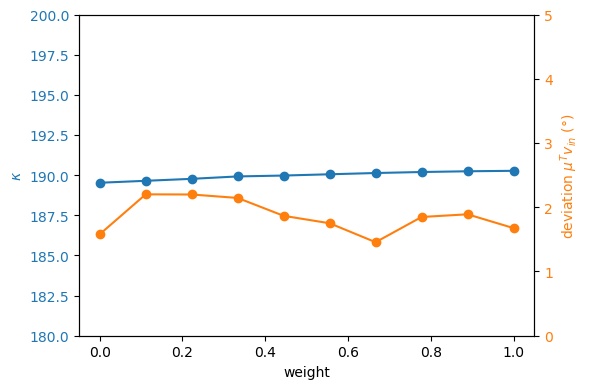

In [401]:
vin = peak_cross[:3] / np.linalg.norm(peak_cross[:3])

k = []
dev=[]
plt.figure(dpi=100)
weights = np.linspace(0, 1, 10)
for w in weights:
    vox = from_single_to_cross(w)
    block = make_uniform_block(vox)
    mu, kappa = predict(model, vin, block)
    k.append(kappa)
    dev.append(np.arccos(np.sum(mu*vin)) / np.pi *180)
    
fig, ax1 =plt.subplots(dpi=100)
ax1.plot(weights, k, "-o", color="tab:blue")
ax1.set_xlabel("weight")
ax1.set_ylabel(r"$\kappa$", color="tab:blue")
ax1.tick_params(axis='y', labelcolor="tab:blue")
ax1.set_ylim(180,200)

ax2 = ax1.twinx()
ax2.plot(weights, dev, "-o", color="tab:orange")
ax2.set_ylabel(r"deviation $\mu^Tv_{in}$ (°)", color="tab:orange")
ax2.tick_params(axis='y', labelcolor="tab:orange")
ax2.set_ylim(0,5)
fig.tight_layout() 

In [30]:
def closeness(i):
    dist = np.linalg.norm(np.array(np.unravel_index(i, (3,3,3))) - (1,1,1))
    if dist < 1:
        return "r"
    
    elif dist < np.sqrt(2):
        return "orange"
    
    
    elif dist < np.sqrt(3):
        return "g"
    else:
        return "b"

In [31]:
def aheadness(i):
    idx = np.array(np.unravel_index(i, (3,3,3)))
    if idx[0] == 2:
        return "r"
    
    elif idx[0] == 1:
        return "orange"
    
    elif idx[0] == 0:
        return "g"
    else:
        return "b"

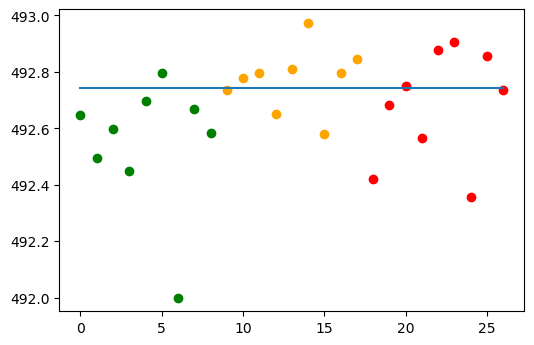

In [32]:
vin = [0,1,0]

plt.figure(dpi=100)
idx = np.arange(27)
for i in idx:
    d = make_uniform_block(vox_si, knockout=i)
    _, kappa = predict(model, vin, d)
    plt.plot(i, kappa, "o", color=aheadness(i))
d = make_uniform_block(vox_si)
_, kappa = predict(model, vin, d)
plt.plot([0,26],[kappa, kappa]);

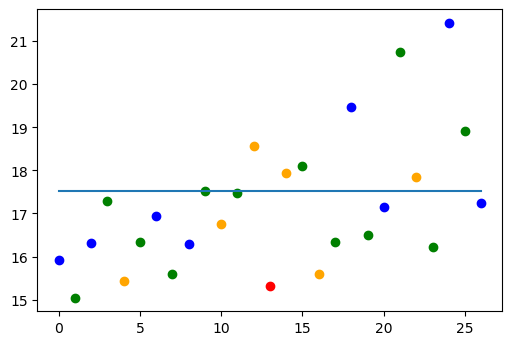

In [33]:
vin = [0,1,0]

plt.figure(dpi=100)
idx = np.arange(27)
for i in idx:
    d = make_uniform_block(vox_lr, knockout=i)
    mu, _ = predict(model, vin, d)
    dev = np.arccos(np.sum(mu*vin)) / np.pi *180
    plt.plot(i, dev, "o", color=closeness(i))
    
d = make_uniform_block(vox_lr)
mu, _ = predict(model, vin, d)
dev = np.arccos(np.sum(mu*vin)) / np.pi *180
plt.plot([0,26],[dev, dev]);

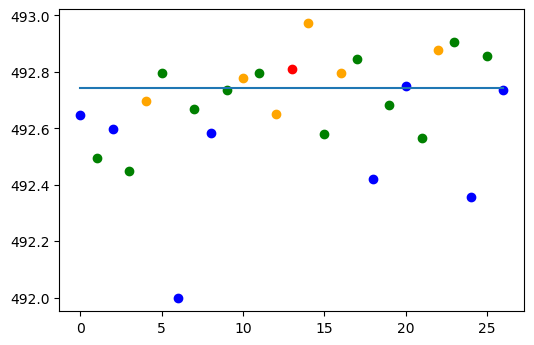

In [34]:
vin = [0,1,0]

plt.figure(dpi=100)
idx = np.arange(27)
for i in idx:
    d = make_uniform_block(vox_si, knockout=i)
    _, kappa = predict(model, vin, d)
    plt.plot(i, kappa, "o", color=closeness(i))
    
d = make_uniform_block(vox_si)
_, kappa = predict(model, vin, d)
plt.plot([0,26],[kappa, kappa]);

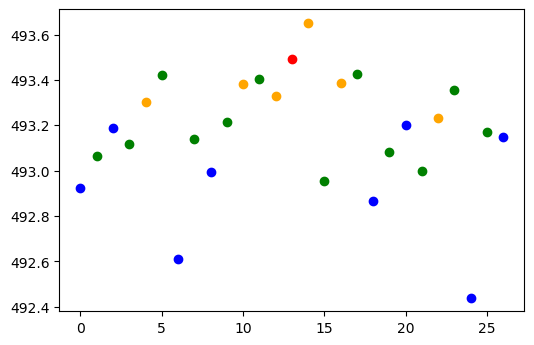

In [35]:
vin = [0,1,0]

plt.figure(dpi=100)
idx = np.arange(27)
for i in idx:
    kappa=0
    for vox in dwi[87-1:87+2,85-1:85+2,84-1:84+2,:].reshape(-1,15):
        d = make_uniform_block(vox, knockout=i)
        _, k = predict(model, vin, d)
        kappa += k / 27
        
    plt.plot(i, kappa, "o", color=closeness(i))

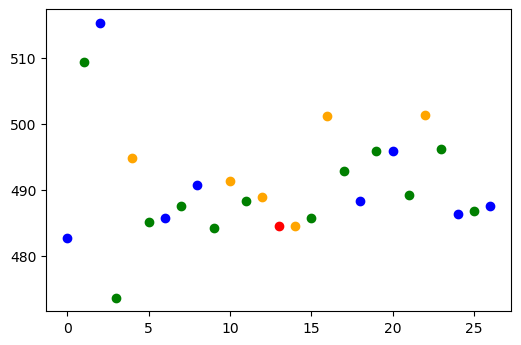

In [36]:
vin = [0,1,0]

plt.figure(dpi=100)
idx = np.arange(27)
for i in idx:
    d = place_vox(vox_lr, i)
    _, kappa = predict(model, vin, d)
    plt.plot(i, kappa, "o", color=closeness(i))

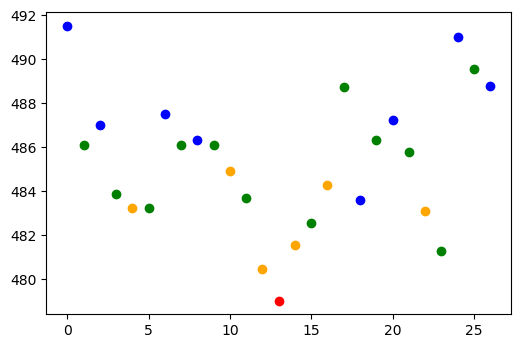

In [37]:
vin = [0,1,0]

plt.figure(dpi=100)
idx = np.arange(27)
for i in idx:
    d = place_vox(vox_ap, i)
    _, kappa = predict(model, vin, d)
    plt.plot(i, kappa, "o", color=closeness(i))

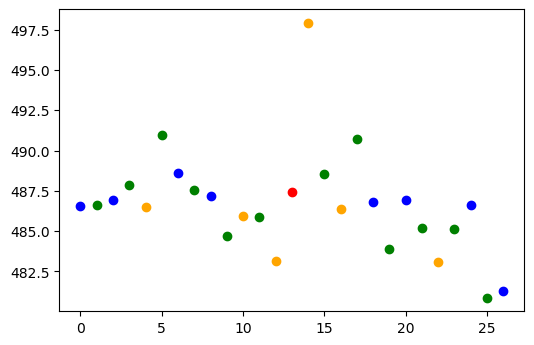

In [38]:
vin = [0,1,0]

plt.figure(dpi=100)
idx = np.arange(27)
for i in idx:
    d = place_vox(vox_si_tilted, i)
    _, kappa = predict(model, vin, d)
    plt.plot(i, kappa, "o", color=closeness(i))